# Naive Bayes — No-Framework Implementation

Two-part pipeline building both Naive Bayes variants from scratch using only NumPy.

**Part 1: GaussianNB** (Breast Cancer — binary classification baseline)
- 455 train / 114 test samples, 30 continuous features, 2 classes
- Implements Gaussian likelihood, log priors, and log-posterior prediction

**Part 2: MultinomialNB** (20 Newsgroups — text classification main event)
- 11,314 train / 7,532 test documents, 10,000 TF-IDF features, 20 categories
- Implements feature log-probabilities with Laplace smoothing, matrix-multiply prediction

**Showcase**: Log-Sum-Exp trick — the numerical stability technique that makes log-space probability computation safe from overflow/underflow.

## What We Build From Scratch
- **Class priors**: log(n_k / n_total) for each class
- **Gaussian likelihood**: log P(x|class) via mean, variance per feature per class
- **Multinomial likelihood**: log P(x|class) via smoothed feature counts
- **Log-posterior prediction**: log_prior + sum(log_likelihoods)
- **Log-sum-exp softmax**: numerically stable probability conversion

In [ ]:
# Step 1: Imports and setup
import sys
import os
import numpy as np

# Add project root to path for utils
sys.path.insert(0, os.path.abspath('../..'))
from utils.data_loader import load_processed_data
from utils.performance import track_performance, track_inference, get_model_size
from utils.metrics import evaluate_classifier, print_metrics
from utils.visualization import (plot_calibration_curve, plot_confusion_matrix,
                                  plot_confusion_matrix_multiclass, plot_per_class_f1)
from utils.results import save_results, add_result, print_comparison

# Configuration
RANDOM_STATE = 113
ALPHA = 1.0            # Laplace smoothing for MultinomialNB
VAR_SMOOTHING = 1e-9   # Variance floor for GaussianNB (prevents division by zero)
FRAMEWORK = 'No-Framework'

# Load both datasets
X_train_g, X_test_g, y_train_g, y_test_g, meta_g = load_processed_data('naive_bayes_gaussian')
X_train_t, X_test_t, y_train_t, y_test_t, meta_t = load_processed_data('naive_bayes_text')

print("=" * 60)
print(f"NAIVE BAYES — {FRAMEWORK}")
print("=" * 60)
print(f"\nPart 1: Breast Cancer (GaussianNB)")
print(f"  Training: {X_train_g.shape[0]} samples, {X_train_g.shape[1]} features")
print(f"  Test:     {X_test_g.shape[0]} samples")
print(f"  Classes:  {meta_g['n_classes']} ({meta_g['class_names']})")
print(f"\nPart 2: 20 Newsgroups (MultinomialNB)")
print(f"  Training: {X_train_t.shape[0]:,} samples, {X_train_t.shape[1]:,} features")
print(f"  Test:     {X_test_t.shape[0]:,} samples")
print(f"  Classes:  {meta_t['n_classes']} categories")

NAIVE BAYES — No-Framework

Part 1: Breast Cancer (GaussianNB)
  Training: 455 samples, 30 features
  Test:     114 samples
  Classes:  2 (['malignant', 'benign'])

Part 2: 20 Newsgroups (MultinomialNB)
  Training: 11,314 samples, 10,000 features
  Test:     7,532 samples
  Classes:  20 categories


In [2]:
# Step 2: GaussianNB training
def gaussian_nb_train(X, y):
    """
    Train a Gaussian Naive Bayes classifier from scratch.

    For each class k and feature j, compute:
    - class_means[k, j] = mean of feature j for samples in class k
    - class_vars[k, j] = variance of feature j for class k + var_smoothing
    - class_log_prior[k] = log(n_k / n_total)

    The variance smoothing (1e-9) prevents division by zero when a feature
    has zero variance within a class. This matches sklearn's default.

    Args:
        X: Training features (n_samples, n_features).
        y: Training labels (n_samples,), integer class indices.

    Returns:
        dict: Trained model parameters {
            'classes': unique class labels,
            'class_means': (n_classes, n_features),
            'class_vars': (n_classes, n_features),
            'class_log_prior': (n_classes,)
        }
    """
    classes = np.unique(y)
    n_classes = len(classes)
    n_samples, n_features = X.shape

    class_means = np.zeros((n_classes, n_features))
    class_vars = np.zeros((n_classes, n_features))
    class_log_prior = np.zeros(n_classes)

    for k, cls in enumerate(classes):
        X_k = X[y == cls]                                    # samples belonging to class k
        class_means[k] = X_k.mean(axis=0)                    # per-feature mean
        class_vars[k] = X_k.var(axis=0) + VAR_SMOOTHING      # per-feature variance + floor
        class_log_prior[k] = np.log(len(X_k) / n_samples)    # log prior

    return {
        'classes': classes,
        'class_means': class_means,
        'class_vars': class_vars,
        'class_log_prior': class_log_prior
    }

# Quick test
gnb_model = gaussian_nb_train(X_train_g, y_train_g)
print(f"[1/2] GaussianNB trained")
print(f"  Classes: {gnb_model['classes']}")
print(f"  Means shape: {gnb_model['class_means'].shape}")
print(f"  Vars shape: {gnb_model['class_vars'].shape}")
print(f"  Log priors: {gnb_model['class_log_prior']}")
print(f"  Prior probabilities: {np.exp(gnb_model['class_log_prior'])}")

[1/2] GaussianNB trained
  Classes: [0 1]
  Means shape: (2, 30)
  Vars shape: (2, 30)
  Log priors: [-0.98449898 -0.46780824]
  Prior probabilities: [0.37362637 0.62637363]


In [3]:
# Step 3: Log-sum-exp trick and GaussianNB prediction
def log_sum_exp(log_values):
    """
    Numerically stable computation of log(sum(exp(x))).

    The naive approach exp(x) overflows for large x values.
    The trick: subtract the max before exponentiating.
        log(sum(exp(x))) = max(x) + log(sum(exp(x - max(x))))

    This is the core of the No-Framework showcase — see the
    demonstration cell later for why this matters.

    Args:
        log_values: Array of log-space values (n_samples, n_classes).

    Returns:
        Array of log(sum(exp(x))) values (n_samples,).
    """
    max_val = np.max(log_values, axis=1, keepdims=True)
    return max_val.squeeze(axis=1) + np.log(np.sum(np.exp(log_values - max_val), axis=1))


def gaussian_nb_predict(model, X):
    """
    Predict class labels and probabilities using trained GaussianNB.

    For each sample, compute the log-posterior for every class:
        log P(class|x) = log P(class) + sum_j log P(x_j | class)

    Where the Gaussian log-likelihood for feature j in class k is:
        log P(x_j | k) = -0.5 * (log(2*pi*var_kj) + (x_j - mean_kj)^2 / var_kj)

    Predictions come from argmax of log-posteriors.
    Probabilities come from softmax via the log-sum-exp trick.

    Args:
        model: Dict from gaussian_nb_train().
        X: Features to predict on (n_samples, n_features).

    Returns:
        y_pred: Predicted labels (n_samples,).
        y_proba: Class probabilities (n_samples, n_classes).
    """
    classes = model['classes']
    means = model['class_means']
    variances = model['class_vars']
    log_prior = model['class_log_prior']

    n_samples = X.shape[0]
    n_classes = len(classes)

    # Compute log-posteriors for all classes
    log_posteriors = np.zeros((n_samples, n_classes))

    for k in range(n_classes):
        # Gaussian log-likelihood: sum across all features
        # log P(x_j | k) = -0.5 * (log(2*pi*var) + (x - mean)^2 / var)
        log_lik = -0.5 * (
            np.log(2 * np.pi * variances[k])           # normalization constant
            + (X - means[k]) ** 2 / variances[k]       # squared deviation
        )
        log_posteriors[:, k] = log_prior[k] + np.sum(log_lik, axis=1)

    # Predictions: class with highest log-posterior
    y_pred = classes[np.argmax(log_posteriors, axis=1)]

    # Probabilities: softmax via log-sum-exp trick
    log_norm = log_sum_exp(log_posteriors)
    y_proba = np.exp(log_posteriors - log_norm[:, np.newaxis])

    return y_pred, y_proba

# Quick test on a few samples
test_pred, test_proba = gaussian_nb_predict(gnb_model, X_test_g[:5])
print(f"[2/2] GaussianNB prediction")
print(f"  Predictions: {test_pred}")
print(f"  Actual:      {y_test_g[:5]}")
print(f"  Proba shape: {test_proba.shape}")
print(f"  Sums to 1:   {np.allclose(test_proba.sum(axis=1), 1.0)}")
print(f"  Sample probs: {test_proba[0]}")

[2/2] GaussianNB prediction
  Predictions: [1 1 1 1 1]
  Actual:      [0 1 1 1 1]
  Proba shape: (5, 2)
  Sums to 1:   True
  Sample probs: [0.17025307 0.82974693]



METRICS — GaussianNB — Breast Cancer
Metric                           Train         Test
-------------------------------------------------
accuracy                        0.9385       0.8947
precision                       0.9509       0.9054
recall                          0.9509       0.9306
f1                              0.9509       0.9178
auc                             0.9592       0.9363
log_loss                        0.7158       1.0123
brier_score                     0.0608       0.0983
ece                             0.3703       0.3590


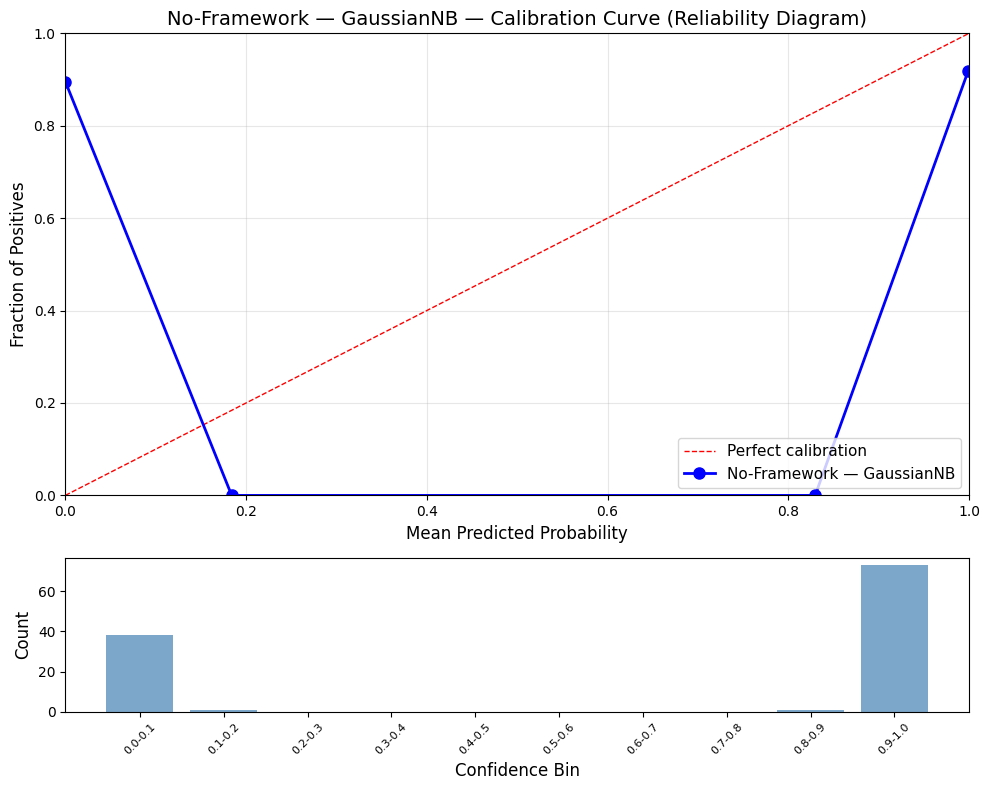

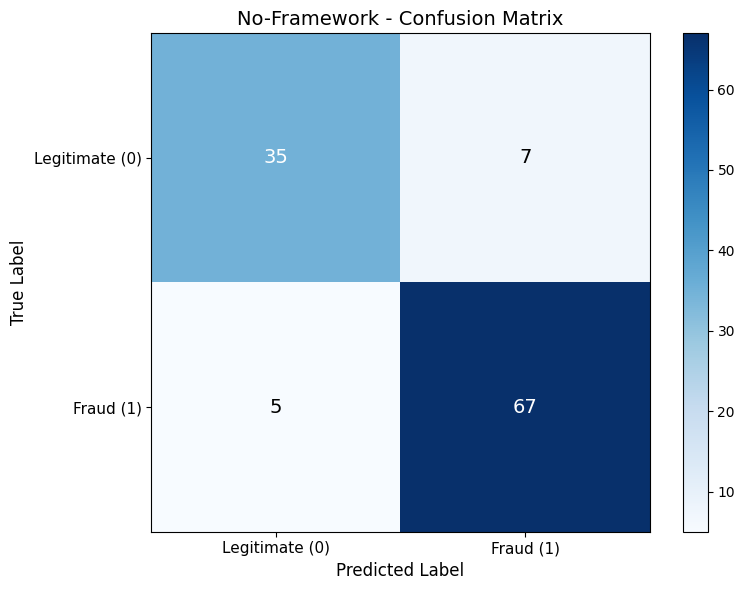


GaussianNB baseline complete.
Key takeaway: 89.5% accuracy, ECE=0.3590


In [4]:
# Step 4: GaussianNB evaluation (Breast Cancer baseline)
"""
Full evaluation on train and test sets.
For binary classification, evaluate_classifier expects P(positive class) as 1D array.
Class 1 = benign (positive class in breast cancer).
"""
train_pred_g, train_proba_g = gaussian_nb_predict(gnb_model, X_train_g)
test_pred_g, test_proba_g = gaussian_nb_predict(gnb_model, X_test_g)

# Binary: pass P(class=1) for probabilistic metrics
train_metrics_g = evaluate_classifier(y_train_g, train_pred_g, train_proba_g[:, 1])
test_metrics_g = evaluate_classifier(y_test_g, test_pred_g, test_proba_g[:, 1])
print_metrics(train_metrics_g, test_metrics_g, title='GaussianNB — Breast Cancer')

# Visualizations
plot_calibration_curve(y_test_g, test_proba_g[:, 1],
                       f'{FRAMEWORK} — GaussianNB',
                       save_path='results/gaussian_calibration.png')

plot_confusion_matrix(y_test_g, test_pred_g, FRAMEWORK,
                      save_path='results/gaussian_confusion_matrix.png')

print(f"\nGaussianNB baseline complete.")
print(f"Key takeaway: {test_metrics_g['accuracy']:.1%} accuracy, "
      f"ECE={test_metrics_g['ece']:.4f}")